In [1]:
#! pip install nibabel -U

In [2]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd

import surface_distance_based_measures

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
task_number = "04"
task_name = "hippocampus".lower()
path = "./Task%s_%s/3d_fullres" % (task_number, task_name.capitalize())
file_prefix = task_name

labels = [1, 2]

run_data = [
    "A40/22933937",
    "A100/22933910",
    "A100/22969078",
    "A100/22972197",
    "A100/22972221",
    "A100/22996510",
]

validation_raw_numbers = [
    "017",
    "019",
    "033",
    "035",
    "037",
    "049",
    "052",
    "065",
    "083",
    "088",
    "090",
    "092",
    "095",
    "107",
    "108",
    "123",
    "125",
    "157",
    "164",
    "169",
    "175",
    "185",
    "190",
    "194",
    "204",
    "205",
    "210",
    "217",
    "219",
    "229",
    "244",
    "261",
    "264",
    "277",
    "280",
    "286",
    "288",
    "289",
    "296",
    "305",
    "308",
    "317",
    "327",
    "330",
    "332",
    "338",
    "349",
    "350",
    "356",
    "358",
    "374",
    "394",
]

results = []

In [5]:
# Calculate DSC: Dice Similarity Coefficient; NSD: Normalized Surface Distance
for run in run_data:

    run_info = {}
    run_info[run] = {}

    for validation_raw_number in validation_raw_numbers:

        run_info[run][validation_raw_number] = {}

        # Ground Truth
        mask_gt_img = nib.load(
            "./Task%s_%s/ground_truth/labelsTr/%s_%s.nii.gz"
            % (task_number, task_name.capitalize(), file_prefix, validation_raw_number)
        )
        mask_gt = np.array(mask_gt_img.dataobj)

        # Run data
        mask_pred_img = nib.load(
            "%s/%s/results/fold_0/validation_raw_postprocessed/%s_%s.nii.gz"
            % (path, run, file_prefix, validation_raw_number)
        )
        mask_pred = np.array(mask_pred_img.dataobj)

        # Calculate the DSC and the NSD for each label separately
        for label in labels:

            run_info[run][validation_raw_number][label] = {}

            # Only include the values that match the label number
            label_mask_gt = (mask_gt == label).astype(int)
            label_mask_pred = (mask_pred == label).astype(int)

            # Calculate Dice Score
            run_info[run][validation_raw_number][label][
                "dice_similarity_coefficient"
            ] = surface_distance_based_measures.compute_dice_coefficient(
                label_mask_gt, label_mask_pred
            )

            # Calculate Normalized Surface Distance
            spacing_mm = (3, 2, 1)
            surface_distances = (
                surface_distance_based_measures.compute_surface_distances(
                    label_mask_gt, label_mask_pred, spacing_mm
                )
            )
            run_info[run][validation_raw_number][label][
                "normalized_surface_distance"
            ] = surface_distance_based_measures.compute_surface_dice_at_tolerance(
                surface_distances, 1
            )

    results.append(run_info)

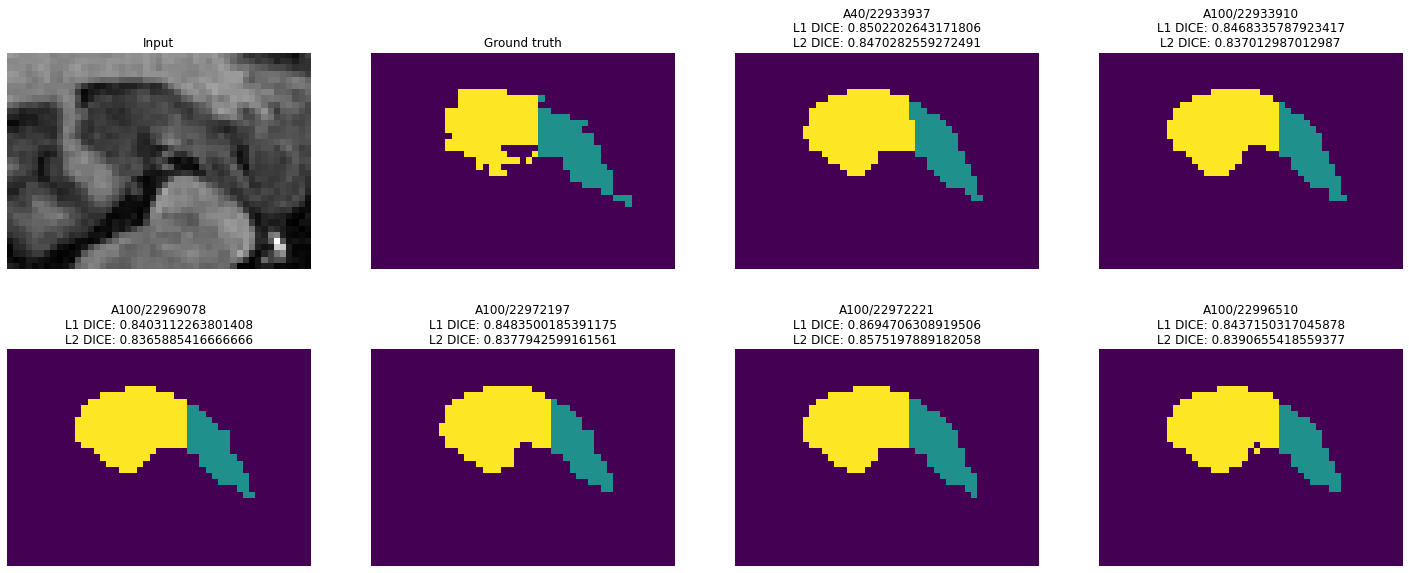

In [6]:
validation_raw_number = "350"
display_layer = 15

# Calculate the number of rows based on the size of results + 2 (input & ground truth)
# and the value of n_cols
n_cols = 4
n_rows = int(np.ceil((len(results) + 2) / n_cols))

# Define the number of rows and columns and set the graph size
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, n_rows * 5))

# Hide the graph axes
for ax in axes.flatten():
    ax.axis("off")

# Display the input image as the first image
axes[0, 0].imshow(
    nib.load(
        "./Task%s_%s/ground_truth/imagesTr/%s_%s.nii.gz"
        % (task_number, task_name.capitalize(), file_prefix, validation_raw_number)
    ).get_fdata()[:, :, display_layer],
    cmap="gray",
)
axes[0, 0].set_title("Input")

# Display the ground truth as the second image
axes[0, 1].imshow(
    nib.load(
        "./Task%s_%s/ground_truth/labelsTr/%s_%s.nii.gz"
        % (task_number, task_name.capitalize(), file_prefix, validation_raw_number)
    ).get_fdata()[:, :, display_layer]
)
axes[0, 1].set_title("Ground truth")


for i, result in enumerate(results):

    # The first key should the run name (ie A100/12345678)
    run = list(result.keys())[0]

    image_path = (
        "%s/%s/results/fold_0/validation_raw_postprocessed/%s_%s.nii.gz"
        % (path, run, file_prefix, validation_raw_number)
    )

    # Use i + 2 instead of i because of the input image and the ground truth always being the first 2 images

    # Calculate the row number by dividing the list item number by the number of columns and rounding down
    row = int(np.floor((i + 2) / n_cols))
    # Calculate the column number by finding the remainder of the list item number divided by the number of columns
    column = int(np.remainder((i + 2), n_cols))

    # Display the display_layer layer of the image
    axes[row, column].imshow(nib.load(image_path).get_fdata()[:, :, display_layer])

    # Set the title the run name and DICE score for each label
    title = "%s" % run
    for label in labels:
        title = "%s\nL%s DICE: %s" % (
            title,
            label,
            result[run][validation_raw_number][label]["dice_similarity_coefficient"],
        )
    axes[row, column].set_title(title)

### Create a list of dataframes for each label with the dice similarity coefficient & normalized surface distance scores

In [7]:
def create_scores_dataframes(score_name):
    scores = []

    # Add a new dataframe to the list for each label
    for label in labels:

        # Create a new dataframe for the label
        label_scores = pd.DataFrame(index=validation_raw_numbers, columns=run_data)

        # Loop through the results
        for result in results:

            # Get the name of the run
            run = list(result.keys())[0]

            # Add the results of the run to the dataframe as a column
            for validation_raw_number in list(result[run].keys()):
                label_scores[run][validation_raw_number] = result[run][
                    validation_raw_number
                ][label][score_name]

        # Add the label scores to the scores list
        scores.append(label_scores)

    return scores

In [8]:
dice_similarity_coefficient_scores = create_scores_dataframes(
    "dice_similarity_coefficient"
)
normalized_surface_distance_scores = create_scores_dataframes(
    "normalized_surface_distance"
)

for idx, label in enumerate(labels):
    print("Label %s:" % label)
    print("Dice Similarity Coefficient:")
    display(dice_similarity_coefficient_scores[idx].head())
    print("Normalized Surface Distance:")
    display(normalized_surface_distance_scores[idx].head())

Label 1:
Dice Similarity Coefficient:


,A40/22933937,A100/22933910,A100/22969078,A100/22972197,A100/22972221,A100/22996510
017,0.929672,0.926818,0.931927,0.930927,0.929409,0.927159
019,0.889342,0.884802,0.891609,0.893519,0.889846,0.892583
033,0.892282,0.888641,0.895291,0.895798,0.893842,0.900644
035,0.904814,0.912452,0.917756,0.90674,0.915832,0.909735
037,0.838083,0.836169,0.833542,0.842505,0.838226,0.841509


Normalized Surface Distance:


,A40/22933937,A100/22933910,A100/22969078,A100/22972197,A100/22972221,A100/22996510
017,0.977133,0.977312,0.980881,0.979625,0.981904,0.975501
019,0.914401,0.910413,0.918013,0.920847,0.911702,0.915763
033,0.907138,0.903532,0.913103,0.912179,0.915981,0.910373
035,0.93492,0.940367,0.95306,0.937943,0.948107,0.940165
037,0.842794,0.840933,0.839505,0.847929,0.839465,0.844492


Label 2:
Dice Similarity Coefficient:


,A40/22933937,A100/22933910,A100/22969078,A100/22972197,A100/22972221,A100/22996510
017,0.912553,0.91112,0.911402,0.922487,0.915385,0.910975
019,0.853859,0.845545,0.848168,0.846989,0.843791,0.846129
033,0.871681,0.874168,0.872509,0.874084,0.871356,0.877326
035,0.882859,0.877065,0.886017,0.882137,0.885355,0.881119
037,0.841215,0.836076,0.842138,0.838771,0.835634,0.842238


Normalized Surface Distance:


,A40/22933937,A100/22933910,A100/22969078,A100/22972197,A100/22972221,A100/22996510
017,0.971356,0.971371,0.969672,0.97363,0.979736,0.977513
019,0.917292,0.903736,0.915404,0.915852,0.912372,0.908368
033,0.900995,0.90752,0.901659,0.897803,0.903485,0.912597
035,0.934921,0.928036,0.940219,0.933355,0.931931,0.929967
037,0.917385,0.921885,0.9218,0.917344,0.916669,0.916592


### Print the mean dice similarity coefficient and normalized surface distance scores for each label

In [9]:
for idx, label in enumerate(labels):
    print("Label %s:" % label)
    print("Dice Similarity Coefficient:")
    print(dice_similarity_coefficient_scores[idx].mean(axis=0))
    print("Normalized Surface Distance:")
    print(normalized_surface_distance_scores[idx].mean(axis=0))
    print()

Label 1:
Dice Similarity Coefficient:
A40/22933937     0.899076
A100/22933910    0.898054
A100/22969078    0.899706
A100/22972197    0.898927
A100/22972221    0.899319
A100/22996510    0.898927
dtype: float64
Normalized Surface Distance:
A40/22933937     0.926680
A100/22933910    0.926349
A100/22969078    0.928687
A100/22972197    0.927458
A100/22972221    0.927614
A100/22996510    0.927022
dtype: float64

Label 2:
Dice Similarity Coefficient:
A40/22933937     0.883353
A100/22933910    0.883695
A100/22969078    0.883529
A100/22972197    0.883548
A100/22972221    0.883081
A100/22996510    0.882745
dtype: float64
Normalized Surface Distance:
A40/22933937     0.930653
A100/22933910    0.931787
A100/22969078    0.931223
A100/22972197    0.931653
A100/22972221    0.931007
A100/22996510    0.930508
dtype: float64

